### This notebook uses the encoded data from Sonia

In [14]:
from sklearn import datasets
from sklearn import model_selection  
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import neighbors
from sklearn import svm
from sklearn import ensemble
from sklearn import cluster
from sklearn import preprocessing
from sklearn import pipeline

import numpy as np
import pandas as pd
# Note: My latest version of Pandas is always showing a FutureWarning. Turning off Warnings for brevity:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import seaborn.objects as so

In [15]:
redfin = pd.read_csv('../3_data_cleaned/redfin_market_tracker_encoded.csv')
redfin = redfin.dropna()
print(redfin.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               1406 non-null   int64  
 1   median_sale_price                        1406 non-null   float64
 2   median_list_price                        1406 non-null   float64
 3   homes_sold                               1406 non-null   float64
 4   pending_sales                            1406 non-null   float64
 5   new_listings                             1406 non-null   float64
 6   inventory                                1406 non-null   float64
 7   months_of_supply                         1406 non-null   float64
 8   median_dom                               1406 non-null   float64
 9   avg_sale_to_list                         1406 non-null   float64
 10  sold_above_list                          1406 no

In [140]:
# Prepare data for regression
X = redfin[['median_list_price', "interest_rate","region_Nassau County, NY","region_Suffolk County, NY","property_type_All Residential","property_type_Condo/Co-op","property_type_Multi-Family (2-4 Unit)","property_type_Single Family Residential","property_type_Townhouse","period_begin"]]
y = redfin['median_sale_price']

# Split data into training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.7)

In [141]:
regressor = linear_model.LinearRegression()

# Fit the regressor
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

In [142]:
result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# append result to Redfin
redfin['predicted_median_sale_price_simple_linear'] = regressor.predict(X)
print(result.head(10))
# Calculate performance metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('R-squared:', metrics.r2_score(y_test, y_pred))

        Actual      Predicted
1291  353000.0  346244.558932
19    280000.0  176178.795874
758   750000.0  724481.049016
1299  343500.0  333048.096322
640   417500.0  435191.979114
749   401000.0  422032.067526
51    327500.0  480416.579005
1219  343750.0  375726.462781
1252  426045.0  434687.445635
567   437500.0  485003.937337
Mean Absolute Error: 50648.86718446697
R-squared: 0.7102453141233054


In [143]:
# Function to plot:
from operator import itemgetter
current_period = datetime.now().year
property_types = ["property_type_All Residential","property_type_Condo/Co-op","property_type_Multi-Family (2-4 Unit)","property_type_Single Family Residential","property_type_Townhouse"]

def plotRedfinScatter(xVal, yVal):
    plot = sns.scatterplot(x=xVal, y=yVal, data=redfin,
                alpha=getYearAlpha(redfin['period_begin']),
                hue=redfin[property_types].apply(getHue, axis=1))
    plot.set(xlim=(200000, 800000), ylim=(200000, 900000))
    return plot

def getYearAlpha(data):
    dates = pd.to_datetime(data)
    dates = data.map(datetime.fromordinal).astype("string")
    period = dates.str[:4].astype(int)
    return 1 - (current_period - period) / (current_period - period.min())

def getHue(tuple):
    #print(max(tuple, key=lambda x: x))
    for key, value in tuple.items():
        if value == 1.0:
            return key.removeprefix("property_type_")

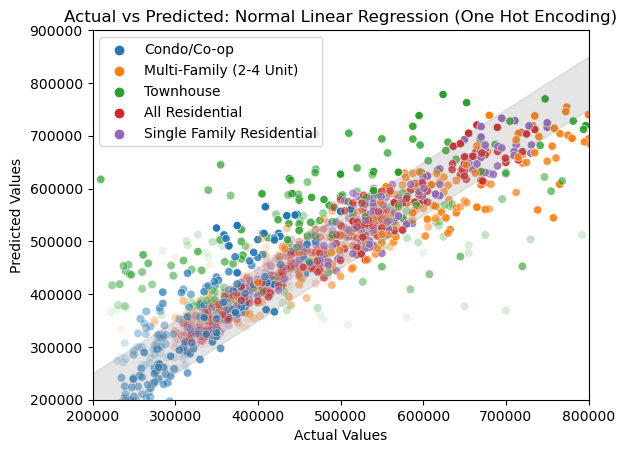

In [144]:
#Seaborn plot
plot = plotRedfinScatter('median_sale_price', 'predicted_median_sale_price_simple_linear')
plot.set(xlabel='Actual Values', ylabel='Predicted Values', title='Actual vs Predicted: Normal Linear Regression (One Hot Encoding)')
plot.fill_between([200000, 800000], [150000, 750000], [250000, 850000],  color='gray', alpha=0.2)

In [87]:
# Let's try a different regression model
regressor = tree.DecisionTreeRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
redfin['predicted_median_sale_price_decision_tree'] = regressor.predict(X)
print(result.head(10))

# Calculate performance metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('R-squared:', metrics.r2_score(y_test, y_pred))

        Actual  Predicted
1382  307500.0   317000.0
362   975000.0  1200000.0
538   700000.0   515000.0
44    400000.0   147659.0
1103  635000.0   486250.0
1309  725000.0   366000.0
991   624000.0  1001875.0
361   540000.0   525000.0
968   655000.0   665000.0
825   579950.0   570000.0
Mean Absolute Error: 61461.66345177665
R-squared: 0.31630432712573175


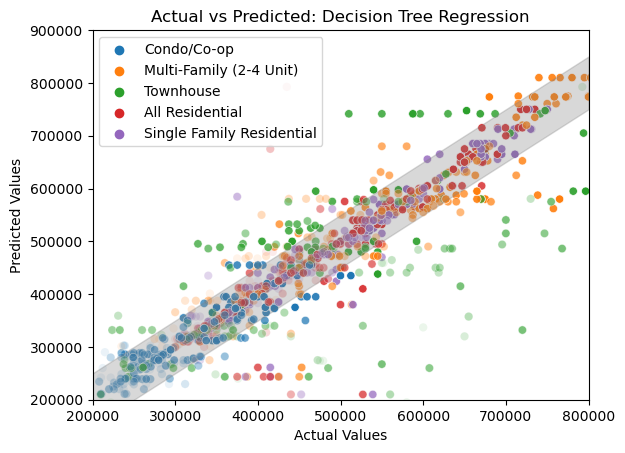

In [88]:
plot = plotRedfinScatter('median_sale_price', 'predicted_median_sale_price_decision_tree')
plot.set(xlabel='Actual Values', ylabel='Predicted Values', title='Actual vs Predicted: Decision Tree Regression')
plot.fill_between([200000, 800000], [150000, 750000], [250000, 850000],  color='gray', alpha=0.3)

In [118]:
# Let's try a different regression model
regressor = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.PoissonRegressor())
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
redfin['predicted_median_sale_price_ridge_regressor'] = regressor.predict(X)
print(result.head(10))

# Calculate performance metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('R-squared:', metrics.r2_score(y_test, y_pred))

        Actual      Predicted
1382  307500.0  370255.745880
362   975000.0  426414.256906
538   700000.0  611915.924838
44    400000.0  397140.449603
1103  635000.0  541306.033903
1309  725000.0  414757.864726
991   624000.0  814377.810340
361   540000.0  488628.699956
968   655000.0  728109.853957
825   579950.0  514238.507196
Mean Absolute Error: 46701.67298929313
R-squared: 0.7142560468656854


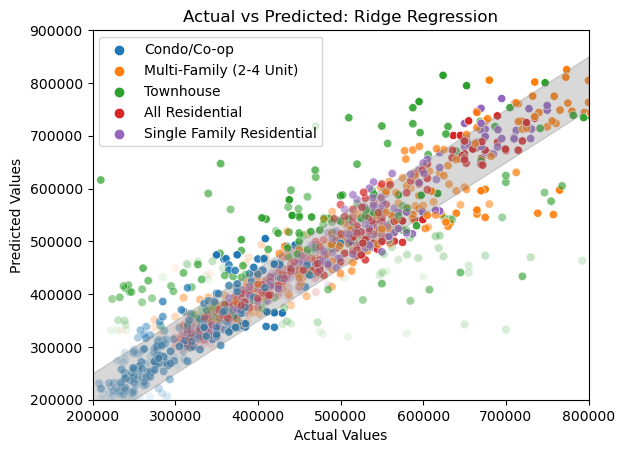

In [119]:
plot = plotRedfinScatter('median_sale_price', 'predicted_median_sale_price_ridge_regressor')
plot.set(xlabel='Actual Values', ylabel='Predicted Values', title='Actual vs Predicted: Ridge Regression')
plot.fill_between([200000, 800000], [150000, 750000], [250000, 850000],  color='gray', alpha=0.3)